# Extract XCO2 from OCO-2 dataset

In [5]:
# some default settings
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

## Import packages

In [6]:
import matplotlib.pyplot as plt # plots
import cartopy.crs as ccrs      # map projections
import pandas as pd             # large arrays
import numpy as np              # large arrays and matrices
import xarray as xr             # major tool to work with NetCDF data!
# custom color map downloaded from GEOS-Chem python tutorial
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
#type(WhGrYlRd)

In [7]:
fname = '/home/msadiq/Desktop/co2/data/satellite/OCO2_b91_10sec_GOOD_r24.nc4'
ds = xr.open_dataset(fname, engine='netcdf4')
#ds # same as print(ds)

### Read in variables and combine them into a Pandas dataframe

In [8]:
dr = ds['xco2']               # column co2 concentration
lon_series = ds['longitude']  # lon and lat
lat_series = ds['latitude']

df_xco2 = pd.DataFrame({'lon': lon_series, 'lat': lat_series, 'xco2': dr})

df_xco2.head()

,lon,lat,xco2
0,160.559998,54.509998,394.339996
1,158.809998,57.750000,394.010010
2,155.000000,63.259998,394.399994
3,154.600006,63.759998,393.190002
4,154.270004,64.169998,394.029999


In [9]:
sound_id = len(ds.coords['sounding_id'].values) # check length of data
print(sound_id)

1319634


In [10]:
# Sort the dataframe by lon and lat indices
df_sorted = df_xco2.sort_values(by=['lon', 'lat'])
df_sorted[df_sorted['lat'].between(-50,30, inclusive = True)]
df_sorted.head()

,lon,lat,xco2
275578,-180.0,-59.110001,397.239990
627308,-180.0,-38.570000,401.739990
224583,-180.0,-34.730000,398.619995
1222133,-180.0,-26.500000,406.119995
666697,-180.0,-26.370001,401.739990


In [11]:
# Check rows with same lon_ind and lat_ind
df_first_lon = df_sorted[df_sorted.lon == -180]
print(df_first_lon[df_first_lon.lat == -38.57])

          lon    lat       xco2
627308 -180.0 -38.57  401.73999


In [12]:
# Creat target grid
lat_res = 1 # resolution of lat and lon you would want
lon_res = 1
lat = np.linspace(-90, 90, 180/lat_res+1)
lon = np.linspace(-180, 180, 360/lon_res+1)
target = xr.DataArray(0, 
                      dims=('lat', 'lon'), 
                      coords={'lat': lat,
                              'lon': lon})
target = target.astype(dtype='float32')
target

<xarray.DataArray (lat: 181, lon: 361)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0

In [13]:
# map XCO2 to target grid
for ilon in np.arange(len(lon)-1):
    for ilat in np.arange(len(lat)-1):
        #print(ilon)
        df_slice_lat = df_sorted[df_sorted['lat'].between(lat[ilat],lat[ilat+1], inclusive = True)]
        df_slice_lon = df_slice_lat[df_slice_lat['lon'].between(lon[ilon],lon[ilon+1], inclusive = True)]
        target[ilat,ilon] = df_slice_lon.xco2.mean()

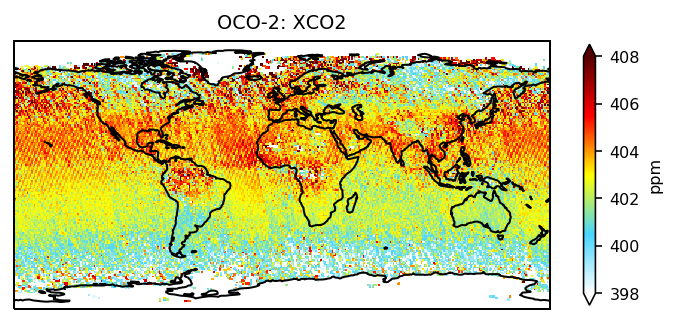

In [14]:
# plot after mapping
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
target.plot(ax=ax, transform=ccrs.PlateCarree(), vmax=408, vmin=398, cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.4, 'label': 'ppm'})

ax.set_title('OCO-2: XCO2');

In [15]:
# save figure
fig.savefig('/home/msadiq/Desktop/co2/satellite/plots/xco2.png', dpi=300)

In [17]:
# save gridded xco2 data
target.name = 'xco2'
target.attrs = dr.attrs
target.attrs['unit'] = 'ppm'
target.attrs['comment'] = 'aggregated from oco-2, by m.sadiq 2020'
target.to_netcdf('/home/msadiq/Desktop/co2/data/satellite/xco2_gridded.nc')

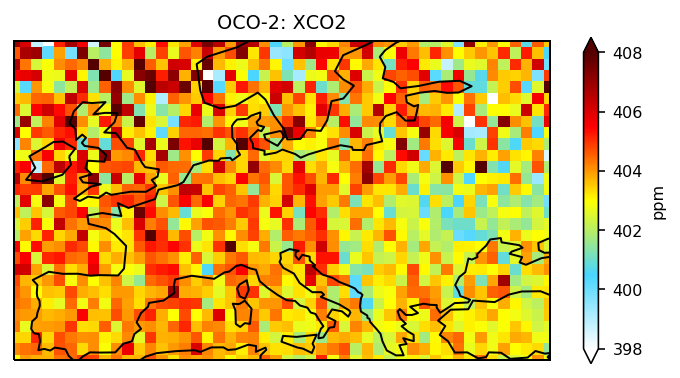

In [18]:
# regional plot
fig = plt.figure(figsize=[6, 6])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
target.plot(ax=ax, cmap=WhGrYlRd, vmax=408, vmin=398, cbar_kwargs={'shrink': 0.5, 'label': 'ppm'})  # The ax keyword is particularly useful for subplots. Can be omitted here.

ax.set_xlim(-11,36)
ax.set_ylim(36,64)
ax.set_title('OCO-2: XCO2');